# Programming language

**Julia 1.6.5**

In [1]:
using Plots; pyplot()
using Plots.Measures
using DelimitedFiles, DataFrames, CSV, JLD
using StatsBase, Distributions,Statistics
using GLM
using Combinatorics
using ProgressMeter
using LaTeXStrings
using LsqFit
using KernelDensity
using SpecialFunctions

## 1. Defining various functions

In [5]:
p_modal(f,threshold) = begin
    
    # This function defines the g(f) curve.
    # You can choose from various options below or define your own g(f)
    
    ## two linear function, without zeros in 0<f<0.5, unimodal R2
    
    # if f <= threshold
    #     (1/threshold)*f
    # else
    #     (1-f)/(1-threshold)
    # end
    
    ## asymmetric g(f), unimodal R2
    
    sin(f*(2*pi-1)+1)
    
    ## asymmetric g(f), with zeros in 0<f<0.5, bimodal R2
    
    # if f <= threshold
    #     (-1)^((f-0.25)<0)*0.5*(2*abs(0.5*cos(f*2*pi+pi)))^0.5  +0.5
    # else
    #     (-1)^((f-0.75)>0)*0.5*(2*(2-2*f-0.5))^4 + 0.5
    # end
    
    ## symmetric, zero R2
    
    # sin(10*f*(1-f)) # another nonlinear function
    
    # exp(-10*abs(f-0.5)^2) # another nonlinear function
    
    ## asymmetric random function with multimodal R2
    
    # sin(30*f^2)
    
    ## antisymmetric function
    
    # sin(100*(f-0.5)^3)
    
    # -f
    
    
end

p_linear(f) = begin
    f
end

## below, you can find functions to model additive multi-QTL phenotype-genotpe maps

p_1QTL(f_marker) = begin
    
    (f_marker > 0.5) * 1
    
end

p_2QTLs(f_markers) = begin
    
    f_marker1,f_marker2 = f_markers
    (f_marker1 == f_marker2) * 1
    
end

p_3QTLs(f_markers) = begin
    
    f_marker1,f_marker2,f_marker3 = f_markers
    f_marker1 * 1 + f_marker2 * 1 + f_marker3 * 1
    
end

p_4QTLs(f_markers) = begin
    
    f_marker1,f_marker2,f_marker3,f_marker4 = f_markers
    f_marker1 * 1 + f_marker2 * 1 + f_marker3 * 1 + f_marker4 * 1
    
end

# function to get ancestry for a particular marker at relative position l

anc(l,f,side) = begin
    
    if f*(1-f)==0
        
        return f
        
    else
        
        return side == 1 ? (l<=f)*1 : (l>=f)*1
        
    end
    
end

# function to get ancestry for a pair of markers at relative position l1 and l2

anc_2(l1,l2,f,side) = begin
    
    if f*(1-f)==0
        
        return [f,f]
        
    else
    
        if side == 1
            # introgress from the left end 
            [l1<=f,l2<=f] .* 1     
        else
            # introgress from the right end
            [l1>=f,l2>=f] .* 1     
        end
        
    end
end

anc_3(l1,l2,l3,f,side) = begin
    
    if f*(1-f)==0
        
        return [f,f,f]
        
    else
    
        if side == 1
            # introgress from the left end 
            [l1<=f,l2<=f,l3<=f] .* 1     
        else
            # introgress from the right end
            [l1>=f,l2>=f,l3>=f] .* 1     
        end
        
    end
end

anc_4(l1,l2,l3,l4,f,side) = begin
    
    if f*(1-f)==0
        
        return [f,f,f,f]
        
    else
    
        if side == 1
            # introgress from the left end 
            [l1<=f,l2<=f,l3<=f,l4<=f] .* 1     
        else
            # introgress from the right end
            [l1>=f,l2>=f,l3>=f,l4>=f] .* 1     
        end
        
    end
end

# function to get average ancestry for the chromosome

anc_Z(f,side) = begin
    
    if f*(1-f) == 0
        return f
    else
        return side == 1 ? f : (1-f)
    end
    
end



anc_Z (generic function with 1 method)

## 2. Inspect the chosen $g(f)$

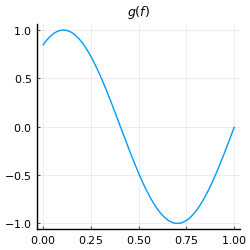

In [6]:
x=0:0.001:1
fig = plot(size=(250,250))

plot!(fig,x,p_modal.(x,0.1),
    label="",
    title=L"g(f)",
    titlefontsize=9,
    )

## 3. Get results for 1-marker scans

In [13]:
# sample size
N = 10000

# total numbers of independent simulations
n_repeats = 1

L = 0.001:0.001:0.999 # relative positions

R2_1marker_additive_all = zeros(length(L),0)

@showprogress 1 for n in 1:n_repeats

    # random breakpoints
    f = begin
        X = []
        for i in 1:N
            if rand(1)[1] <= 0.5           
                x = rand([0,1])
            else
                x = rand(1)
            end
            append!(X,x)
        end
        X
    end

    # random sides

    s = ((rand(N) .<=0.5) * 1).+1

    # get phenotype

    P = p_modal.(anc_Z.(f,s),0.1);
    # P = p_2QTL.(anc_2.(0.1,0.9,f,s));

    # get chromosomal ancestry

    fZ = anc_Z.(f,s);
    
    R2_1marker_additive = []

    R2_Z_ancestry = (cor(fZ,P))^2

    for l in L

        a = [anc(l,f[i],s[i]) for i in 1:N]
        append!(R2_1marker_additive,(cor(a,P))^2)

    end
    
    R2_1marker_additive_all = hcat(R2_1marker_additive_all,R2_1marker_additive)
    
    print(var(p_modal.(fZ,0.1)))
    
end

0.4236262914764169

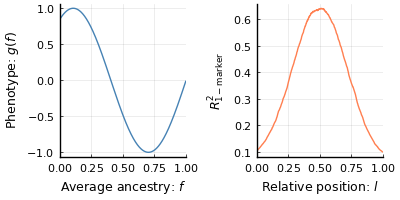

In [14]:
fig = plot(size=(400,200),layout=(1,2))


plot!(fig,L,mean(R2_1marker_additive_all;dims=2),
    label="",
    xlabel=string("Relative position: ",L"l"),
    xlabelfontsize=9,
    linecolor=:coral,
    alpha=1,
    # yticks=0:0.2:1.25,
    # title="",
    # titlefontsize=10,
    ylabel=L"R^2_{\mathrm{1-marker}}",
    ylabelfontsize=9,
    # ylims=(0,0.1),
    xticks=[0,0.25,0.5,0.75,1],
    xlims=(0,1),
    subplot=2,
    )


plot!(fig,L,p_modal.(L,0.25),
    label="",
    xlims=(0,1),
    xticks=[0,0.25,0.5,0.75,1],
    # ylims=(0,1),
    ylabel=string("Phenotype: ", L"g(f)"),
    xlabel=string("Average ancestry: ",L"f"),
    xlabelfontsize=9,
    ylabelfontsize=9,
    subplot=1,
    linecolor=:steelblue,
    )

fig

In [139]:
dir_output = "DIR_OUT"

fig_name = ""

savefig(fig,string("$(dir_output)/$(fig_name).png"))
savefig(fig,string("$(dir_output)/$(fig_name).pdf"))

## 4. Get results for 2-marker scans

In [22]:
# sample size
N = 10000

# random breakpoints
f = begin
    X = []
    for i in 1:N
        if rand(1)[1] <= 0.5           
            x = rand([0,1])
        else
            x = rand(1)
        end
        append!(X,x)
    end
    X
end

# random sides

s = ((rand(N) .<=0.5) * 1).+1

# get phenotype

P = p_modal.(anc_Z.(f,s),0.1);

In [23]:
dl = 0.01
L = 0.01:dl:0.99
# R2_2qtl_additive = zeros(size(L)[1],size(L)[1])

R2_2qtl_v0 = zeros(size(L)[1],size(L)[1]).*NaN
α12_2qtl_v0 = zeros(size(L)[1],size(L)[1]).*NaN

R2_2qtl_v1 = zeros(size(L)[1],size(L)[1]).*NaN
α12_2qtl_v1 = zeros(size(L)[1],size(L)[1]).*NaN

# R2_Z_ancestry = (cor(fZ,P))^2

i = 1
for l1 in L
    j = 1
    for l2 in L[1]:dl:l1
        a = [anc_2(l1,l2,f[i],s[i]) for i in 1:N]
        a = vcat((transpose(a))...)
        
        data = DataFrame(y = P, x1 = 2 .* a[:,1] .- 1, x2=2 .* a[:,2] .- 1)
        ols_sq = lm(@formula(y ~ 1 + x1 & x2), data);
        R2_2qtl_v0[i,j] = r2(ols_sq)     
        α12_2qtl_v0[i,j] = coef(ols_sq)[2]
        
        if (i == 1) & (j == 1)
            println(ols_sq)
        end
        
        data = DataFrame(y = P, x1 = 2 .* a[:,1] .- 1, x2=2 .* a[:,2] .- 1)
        ols_sq = lm(@formula(y ~ 1 + x1 + x2 + x1 & x2), data);
        R2_2qtl_v1[i,j] = r2(ols_sq)     
        α12_2qtl_v1[i,j] = coef(ols_sq)[4]
        
        if (i == 1) & (j == 1)
            println(ols_sq)
        end
        
        j = j+1
    end
    i = i+1
end

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x1 & x2

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                Coef.    Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  0.166464    0.00644808   25.82    <1e-99    0.153825    0.179104
x1 & x2      0.0       NaN           NaN       NaN     NaN         NaN
─────────────────────────────────────────────────────────────────────────────
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x1 + x2 + x1 & x2

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                 Coef.    Std. E

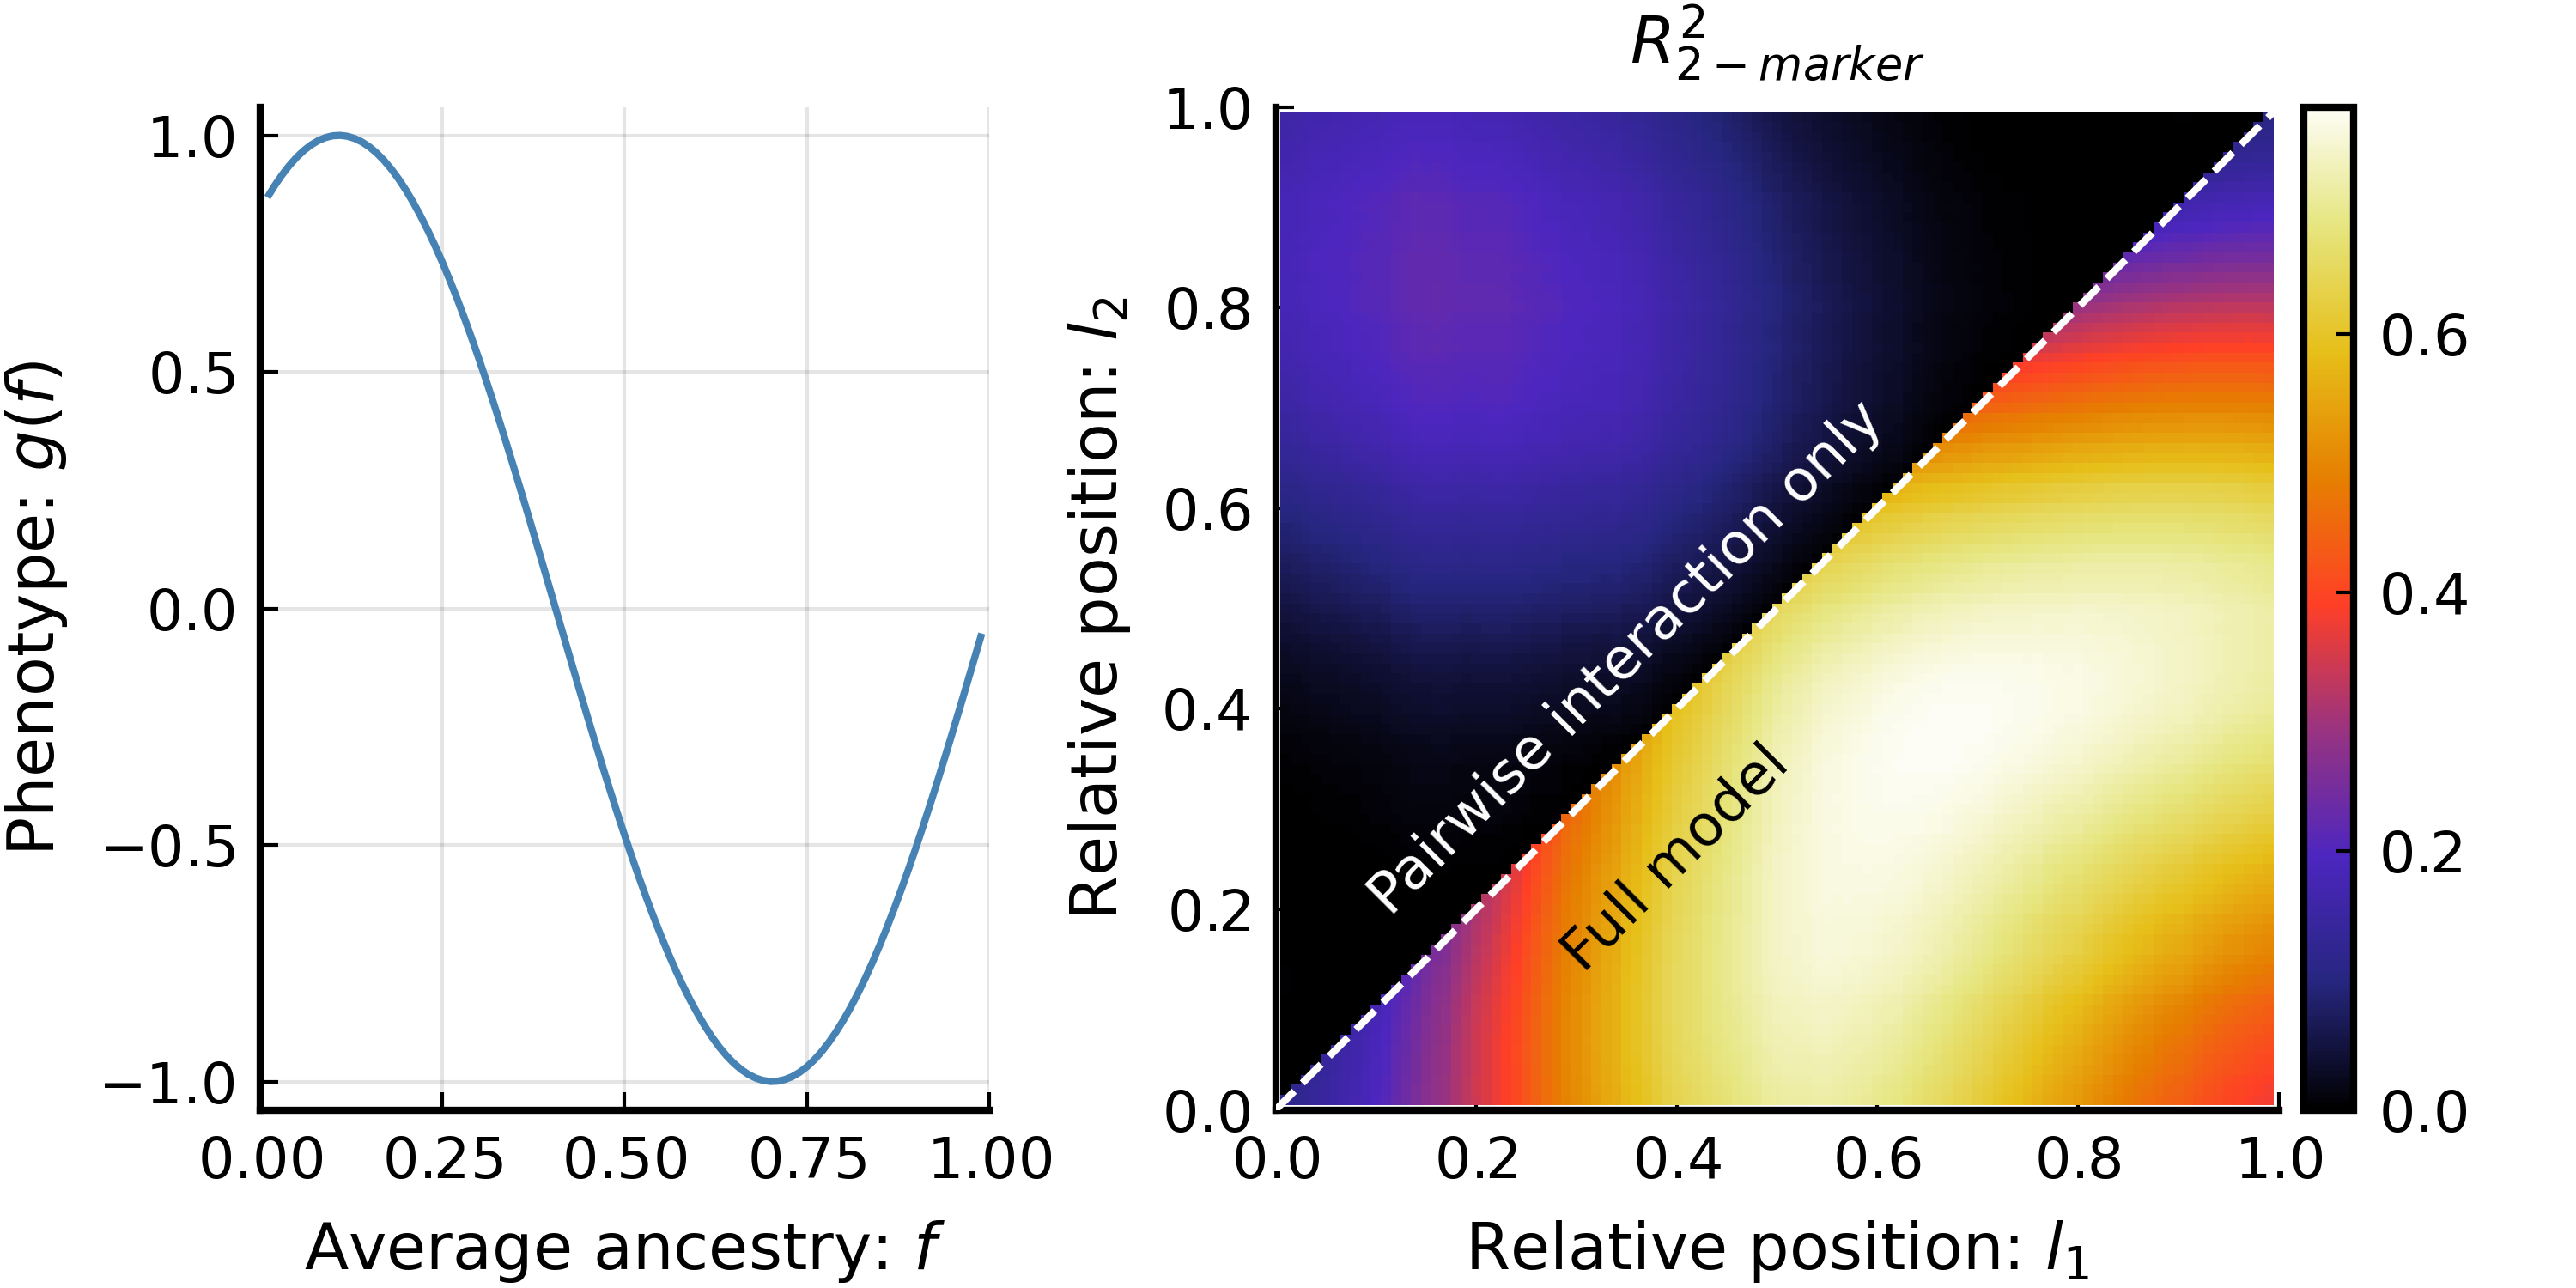

In [24]:
l = @layout[a{0.4w} b]

fig = plot(size=(500,250),layout=l,dpi=600)

plot!(fig,L,p_modal.(L,0.1),
    label="",
    xlims=(0,1),
    xticks=[0,0.25,0.5,0.75,1],
    # ylims=(0,1),
    ylabel=string("Phenotype: ", L"g(f)"),
    xlabel=string("Average ancestry: ",L"f"),
    xlabelfontsize=9,
    ylabelfontsize=9,
    subplot=1,
    linecolor=:steelblue,
    )

heatmap!(fig,L,L,R2_2qtl_v0,
    # color=cgrad(:blackbody,rev=true),
    color=cgrad(:CMRmap),
    # clims=(0,1),
    title=string(L"R^2_{2-marker}"),
    titlefontsize=9,
    xlabelfontsize=9,
    ylabelfontsize=9,
    xlabel=string("Relative position: ",L"l_1"),
    ylabel=string("Relative position: ",L"l_2"),
    grid=:off,
    aspect_ratio=1,
    subplot=2
)

heatmap!(fig,L,L,transpose(R2_2qtl_v1),
    # color=cgrad(:blackbody,rev=true),
    color=cgrad(:CMRmap),
    # clims=(0,1),
    title=string(L"R^2_{2-marker}"),
    titlefontsize=9,
    xlabel=string("Relative position: ",L"l_1"),
    ylabel=string("Relative position: ",L"l_2"),
    grid=:off,
    xlims=(0,1),
    ylims=(0,1),
    aspect_ratio=1,
    subplot=2,
)

annotate!(fig,
    [(0.35,0.45,Plots.text("Pairwise interaction only",8,rotation=45,:white)),
        (0.4,0.25,Plots.text("Full model",8,rotation=45,:black))],
    subplot=2,
)

plot!(fig,
    [0,1],[0,1],
    linecolor=:white,
    linestyle=:dash,
    label="",
    subplot=2)

In [54]:
dir_output = "DIR_OUT"

fig_name = ""

savefig(fig,string("$(dir_output)/$(fig_name).png"))
savefig(fig,string("$(dir_output)/$(fig_name).pdf"))